# Modelling tides

## Using `model_tides`

To model tide heights for a specific location and set of timesteps, we can use the `eo_tides.model.model_tides` function. 
For example, we can model hourly tides across a one month period (January 2028):

In [3]:
from eo_tides.model import model_tides
import pandas as pd

tide_df = model_tides(
    x=122.2186, 
    y=-18.0008, 
    time=pd.date_range("2018-01-01", "2018-01-20", freq="1h"), 
    directory="../../tests/data/tide_models_tests"
)

# Print outputs
tide_df.head()

Modelling tides using FES2014


,,,tide_model,tide_m
time,x,y,,
2018-01-01 00:00:00,122.2186,-18.0008,FES2014,1.285507
2018-01-01 01:00:00,122.2186,-18.0008,FES2014,2.360098
2018-01-01 02:00:00,122.2186,-18.0008,FES2014,2.573156
2018-01-01 03:00:00,122.2186,-18.0008,FES2014,2.035899
2018-01-01 04:00:00,122.2186,-18.0008,FES2014,1.126837


Tide heights for each time and coordinate are included in the `tide_m` column above  (representing tide height in metres relative to Mean Sea Level).

We can also plot out resulting tides to view how tides changed across this month. 
By looking at the y-axis, we can see that tides ranged from a minimum of ~-4 metres up to a maximum of +4 metres relative to Mean Sea Level:

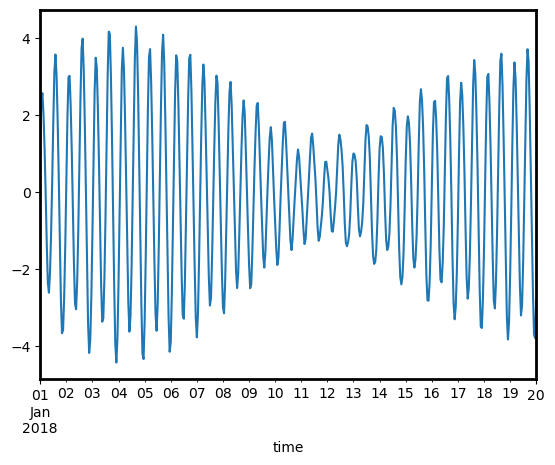

In [4]:
tide_df.reset_index(["x", "y"]).tide_m.plot();

### "One-to-many" and "one-to-one" modes

By default, the `model_tides` function operates in **"one-to-many"** mode, which will model tides for every requested timestep, at every requested location.
For example, if we provided five x, y coordinates and five timesteps, the function would return:
```
5 locations * 5 timesteps = 25 modelled tides
```

However, often you may have a list of locations and matching timesteps.
Using **"one-to-one"** mode, we can model tides for only these exact pairs of locations and times:
```
5 timesteps at 5 locations = 5 modelled tides
```

To demonstrate "one-to-one" mode, imagine we have a `pandas.Dataframe` where each row contains unique site locations and times:

In [5]:
sites_df = pd.DataFrame(
    {
        "time": pd.date_range(start="2022-09-01", end="2022-09-30", periods=5),
        "x": [122.21, 122.22, 122.23, 122.24, 122.25],
        "y": [-18.20, -18.20, -18.20, -18.20, -18.20],
    }
)

sites_df

,time,x,y
0,2022-09-01 00:00:00,122.21,-18.2
1,2022-09-08 06:00:00,122.22,-18.2
2,2022-09-15 12:00:00,122.23,-18.2
3,2022-09-22 18:00:00,122.24,-18.2
4,2022-09-30 00:00:00,122.25,-18.2


Using "one-to-one" mode, we can model a tide height for each row in our dataframe, and add it as a new dataframe column:

In [6]:
# Model tides in "one-to-one" mode
onetoone_df = model_tides(
    x=sites_df.x,
    y=sites_df.y,
    time=sites_df.time,
    mode="one-to-one",
    directory="../../tests/data/tide_models_tests",
)

# Add results as a new datframe column
sites_df["tide_height"] = onetoone_df.tide_m.values
sites_df.style.set_properties(**{"background-color": "#FFFF8F"}, subset=["tide_height"])

Modelling tides using FES2014 in parallel


100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


,time,x,y,tide_height
0,2022-09-01 00:00:00,122.210000,-18.200000,-3.590410
1,2022-09-08 06:00:00,122.220000,-18.200000,-1.642175
2,2022-09-15 12:00:00,122.230000,-18.200000,-3.351815
3,2022-09-22 18:00:00,122.240000,-18.200000,-0.942939
4,2022-09-30 00:00:00,122.250000,-18.200000,-3.613317


### Validation against GESLA tide gauges

In [7]:
from eo_tides.validation import eval_metrics, load_gauge_gesla

# Load gauge data, subtracting to observed mean sea level
gauge_df = load_gauge_gesla(
    x=122.3186,
    y=-18.0008,
    time=("2018-01-01", "2018-01-20"),
    correct_mean=True,
    data_path="../../tests/data/",
    metadata_path="../../tests/data/GESLA3_ALL 2.csv",
)
gauge_df.head()


/env/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/home/jovyan/Robbi/eo-tides/eo_tides/validation.py:157: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  pd.read_csv(


sea_level  qc_flag  use_flag  \
site_code time                                                
62650     2018-01-01 00:00:00   1.204227        1         1   
          2018-01-01 01:00:00   2.307227        1         1   
          2018-01-01 02:00:00   2.708227        1         1   
          2018-01-01 03:00:00   2.133227        1         1   
          2018-01-01 04:00:00   1.045227        1         1   

                                                           file_name  \
site_code time                                                         
62650     2018-01-01 00:00:00  ../../tests/data/broome-62650-aus-bom   
          2018-01-01 01:00:00  ../../tests/data/broome-62650-aus-bom   
          2018-01-01 02:00:00  ../../tests/data/broome-62650-aus-bom   
          2018-01-01 03:00:00  ../../tests/data/broome-62650-aus-bom   
          2018-01-01 04:00:00  ../../tests/data/broome-62650-aus-bom   

                              site_name country contributor_abbreviated  \
site_code time                                                            
62650     2018-01-01 00:00:00    Broome     AUS                     BOM   
          2018-01-01 01:00:00    Broome     AUS                     BOM   
          2018-01-01 02:00:00    Broome     AUS                     BOM   
          2018-01-01 03:00:00    Broome     AUS                     BOM   
          2018-01-01 04:00:00    Broome     AUS                     BOM   

                                    contributor_full  \
site_code time                                         
62650     2018-01-01 00:00:00  Bureau of Meteorology   
          2018-01-01 01:00:00  Bureau of Meteorology   
          2018-01-01 02:00:00  Bureau of Meteorology   
          2018-01-01 03:00:00  Bureau of Meteorology   
          2018-01-01 04:00:00  Bureau of Meteorology   

                                                             contributor_website  \
site_code time                                                                     
62650     2018-01-01 00:00:00  http://www.bom.gov.au/oceanography/projects/nt...   
          2018-01-01 01:00:00  http://www.bom.gov.au/oceanography/projects/nt...   
          2018-01-01 02:00:00  http://www.bom.gov.au/oceanography/projects/nt...   
          2018-01-01 03:00:00  http://www.bom.gov.au/oceanography/projects/nt...   
          2018-01-01 04:00:00  http://www.bom.gov.au/oceanography/projects/nt...   

                              contributor_contact  ... start_date_time  \
site_code time                                     ...                   
62650     2018-01-01 00:00:00    tides@bom.gov.au  ...  2/07/1966 0:00   
          2018-01-01 01:00:00    tides@bom.gov.au  ...  2/07/1966 0:00   
          2018-01-01 02:00:00    tides@bom.gov.au  ...  2/07/1966 0:00   
          2018-01-01 03:00:00    tides@bom.gov.au  ...  2/07/1966 0:00   
          2018-01-01 04:00:00    tides@bom.gov.au  ...  2/07/1966 0:00   

                                  end_date_time number_of_years  \
site_code time                                                    
62650     2018-01-01 00:00:00  31/12/2019 23:00              51   
          2018-01-01 01:00:00  31/12/2019 23:00              51   
          2018-01-01 02:00:00  31/12/2019 23:00              51   
          2018-01-01 03:00:00  31/12/2019 23:00              51   
          2018-01-01 04:00:00  31/12/2019 23:00              51   

                               time_zone_hours  \
site_code time                                   
62650     2018-01-01 00:00:00                0   
          2018-01-01 01:00:00                0   
          2018-01-01 02:00:00                0   
          2018-01-01 03:00:00                0   
          2018-01-01 04:00:00                0   

                                                    datum_information  \
site_code time                                                          
62650     2018-01-01 00:00:00  Chart Datum / Lowest Astronomical Tide   
          2018-01

Correlation         0.998
RMSE                0.144
MAE                 0.113
R-squared           0.995
Bias                0.004
Regression slope    0.986
dtype: float64

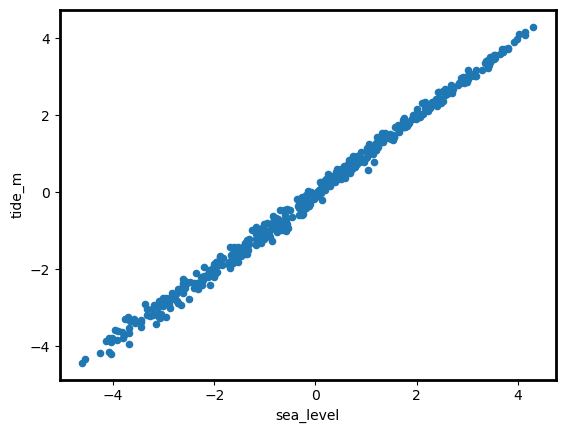

In [8]:
# Combine modelled and observed gauge data and compare
joined_df = gauge_df.join(tide_df)
joined_df.plot.scatter(x="sea_level", y="tide_m")
eval_metrics(x=joined_df.sea_level, y=joined_df.tide_m)